In [98]:
import json
import pandas as pd
import numpy as np
import pymongo
import os.path
import seaborn as sns
import re

from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from collections import defaultdict, Counter

tqdm_notebook().pandas()
sns.set_context('talk')
sns.set_style('whitegrid')

%matplotlib inline

# Load data

## Control and treatment groups

###  Load users information

In [2]:
n_users = pd.read_csv("./nosport_users_stats")
s_users = pd.read_csv("./sport_users_stats")

for df in [n_users, s_users]:
    df.index = df['id']

In [3]:
s_users.shape, n_users.shape

((1160, 7), (1160, 7))

### Load matches

Load matches file.

In [4]:
matches = pd.read_csv("/data/1/sporty/users/classification/matches.txt", header=None, names=['sport', 'nosport'])

Some users have been matched twice to a sport users, we remove these duplicate entries here although we missed them in 2014.

In [5]:
matches = matches.drop_duplicates(subset=['nosport'])
n_users = n_users.drop_duplicates(subset=['id'])

Align users' dataframes.

In [6]:
s_users = s_users.loc[matches.sport.tolist()]
s_users.index = np.arange(s_users.shape[0])
n_users = n_users.loc[matches.nosport.tolist()]
n_users.index = np.arange(n_users.shape[0])

In [7]:
s_users.shape, n_users.shape

((1153, 7), (1153, 7))

Remove users that are in both groups and their match that we missed last time.

In [8]:
# find users in both groups
both_groups = set(s_users['id']) & set(n_users['id'])

# find lines with users in both groups
s_idx_to_remove = s_users.id.where(s_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
n_idx_to_remove = n_users.id.where(n_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
idx_to_remove = s_idx_to_remove + n_idx_to_remove

# remove lines from users' dataframes
s_users = s_users.drop(idx_to_remove, axis=0)
n_users = n_users.drop(idx_to_remove, axis=0)

In [9]:
s_users.shape, n_users.shape

((1137, 7), (1137, 7))

### Load tweets for each user 

In [51]:
def load_tweets(user_id, data_dir, remove_hash=None, keep_rt=False):
    user_p = os.path.join(data_dir, user_id)
    tweets = []
    with open(user_p) as fd:
        for l in fd:
            o = json.loads(l)
            # check for retweets
            if not keep_rt and 'retweeted_status' in o:
                keep_tw = False
            else:
                # check for hashtags to avoid
                h = set([_['text'].lower() for _ in o['entities']['hashtags']])
                keep_tw = remove_hash is None or not (h & set(remove_hash))
            
            if keep_tw:
                tweets.append(o['text'])
    return tweets
    
auto_hash = ['runkeeper', 'nikeplus', 'runtastic', 'endomondo', 'mapmyrun', 'strava', 'cyclemeter', 'fitstats', 'mapmyfitness', 'runmeter']

def load_tweets_sport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/sport/", remove_hash=auto_hash)
    
def load_tweets_nosport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/no_sport/", remove_hash=auto_hash)

In [60]:
s_users['tweets'] = s_users.id.astype(str).progress_apply(load_tweets_sport)
n_users['tweets'] = n_users.id.astype(str).progress_apply(load_tweets_nosport)

In [75]:
s_users['tweets_count'] = s_users.tweets.apply(len)
n_users['tweets_count'] = n_users.tweets.apply(len)

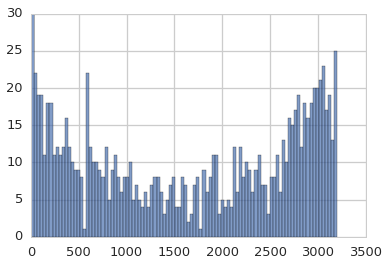

In [76]:
n_users[n_users.tweets_count>0].tweets_count.hist(bins=100,alpha=0.7)

In [82]:
(n_users.tweets_count <= 20).sum()

125

## Mood annotated data

In [86]:
def load_labeled_mood(p):
    tweets = []
    with open(p) as fd:
        for l in tqdm_notebook(fd):
            o = json.loads(l)
            tweets.append({k: o[k] for k in ['text', 'AH', 'DD', 'TA']})
    return pd.DataFrame(tweets)

mood_tweets_df = load_labeled_mood("/data/1/sporty/tweets/labeled/3K_labeled")

### Load LIWC lexicon

In [91]:
''' Data structure and utility functions for reading and querying a LIWC
lexicon. Data described here:
http://homepage.psy.utexas.edu/homepage/faculty/pennebaker/reprints/LIWC2001.pdf
'''

from collections import defaultdict
import os


class Lexicon(object):
    """
    >>> import tempfile
    >>> tf = tempfile.NamedTemporaryFile()
    >>> tf.write("%\\n1\\tPronoun\\n2\\tI\\n3\tGreet\\n%\\ni\\t01 02\\nhis\\t01\\nhi*\t03")
    >>> tf.flush()
    >>> d = Lexicon(tf.name)
    >>> d.categories_for_tokens(['i', 'his'])
    [[u'Pronoun', u'I'], [u'Pronoun']]
    >>> d.categories_for_tokens(['his'])
    [[u'Pronoun']]
    >>> cts = d.counts_for_tokens(['i', 'his'])
    >>> cts[u'I']
    1
    >>> cts[u'Pronoun']
    2
    >>> d.categories_for_tokens(['zebra'])
    [[]]
    >>> d.categories_for_tokens(['hithere'])
    [[u'Greet']]
    """

    def __init__(self, dict_file=None):
        self.dict_file = dict_file
        self.load_dictionary(dict_file)

    def parse_categories(self, catText):
        lines = catText.split("\n")
        self.categories = {}
        for line in lines:
            if len(line) > 0:
                key, val = line.split()
                self.categories[str(key)] = str(val)

    def parse_patterns(self, regExps):
        lines = regExps.split("\n")
        self.exact_patterns = {}
        self.prefix_patterns = {}
        for line in lines:
            if len(line) > 0 and not line.startswith('//'):
                vals = line.split()
                exp = vals[0]
                ids = [str(int(v)) for v in vals[1:]]
                if '*' in exp:
                    self.prefix_patterns[exp[:-1]] = ids
                else:
                    self.exact_patterns[exp] = ids

    def load_dictionary(self, dict_file):
        dict_text = open(dict_file).read()
        as_list = dict_text.split("%")
        self.parse_categories(as_list[1])
        self.parse_patterns(as_list[2])

    def categories_for_token(self, word):
        result = []
        if word in self.exact_patterns:
            result.extend(self.exact_patterns[word])
        else:
            for i in range(0, len(word)):
                if word[:-i] in self.prefix_patterns:
                    result.extend(self.prefix_patterns[word[:-i]])
        return [self.categories[c] for c in result]

    def categories_for_tokens(self, tokens):
        """ Returns a list of lists. For each token, create a list of categories
        it belongs to."""
        return [self.categories_for_token(token) for token in tokens]

    def counts_for_tokens(self, tokens):
        """ Returns a dict mapping categories to counts from this list of
        tokens. """
        cats = self.categories_for_tokens(tokens)
        d = defaultdict(lambda: 0)
        for a in cats:
            for b in a:
                d[b] += 1
        return d
    
lex = Lexicon("./liwc.dic")

###  Load emoticons 

###  Build tokenizer

In [94]:

def tokenize(text):
    text = text.replace("\n", " ").replace("\t", " ").replace("\r\n", " ")
    tokens = text.split()

In [87]:
mood_tweets_df

,AH,DD,TA,text
0,1,0,0,@jodieegentt you're still a fucking nob
1,0,0,1,It's to hot to sleep😁
2,0,0,1,I can't wait to burn all of my school books an...
3,0,0,0,Just staying strong in my faith &amp; pressing...
4,0,0,0,I've listened to hardly any other music apart ...
5,0,0,0,I wild Jeanne is surprised ! http://t.co/fAICx...
6,0,0,0,Alex is so ignorant at this point #bless
7,1,1,1,For the love of fucking god I need to get out ...
8,1,0,0,Peti Filou advert told me to make a milkshake ...
9,0,0,0,hii calum :)\n\ni hope your having a \ngood da...
